In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# from logitlens import LogitLens

In [ ]:
MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
LANGUAGE = "English"
logit_lens = LogitLens(LANGUAGE, MODEL_NAME)
MODEL_NAME = MODEL_NAME.split("/")[-1]
path1 = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{MODEL_NAME}_{LANGUAGE}.csv"
df = pd.read_csv(path1)
df["splitted_tokens"] = df["splitted_tokens"].apply(ast.literal_eval)

Using device: cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Tower-Babel/Babel-9B-Chat for English loaded successfully.


In [59]:
def setup_tokenizer(self):
    if self.tokenizer_name == "Tower-Babel/Babel-9B-Chat":
        self.tokenizer.add_special_tokens({'unk_token': 'UNK'})
        self.tokenizer.unk_token_id = self.tokenizer.convert_tokens_to_ids('UNK')

In [44]:
tokenizer = AutoTokenizer.from_pretrained("Tower-Babel/Babel-9B-Chat", use_fast=True)

In [63]:
from transformers import AutoTokenizer

model_list = [
    "Tower-Babel/Babel-9B-Chat",
    "google/gemma-3-12b-it",
    "meta-llama/Llama-2-7b-chat-hf",
]
language_list = [
    "English",
    "German",
    # "Korean",
]
df_dict = {}
# MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
# LANGUAGE = "English"
for MODEL_NAME in model_list:
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
        
    except:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token="HF_TOKEN_REMOVED")
    if tokenizer.unk_token is None:
        tokenizer.add_special_tokens({'unk_token': 'UNK'})
        tokenizer.unk_token_id = tokenizer.convert_tokens_to_ids('UNK')
    else:
        print(tokenizer.unk_token)
        

    for LANGUAGE in language_list:
        MODEL_NAME = MODEL_NAME.split("/")[-1]
        path1 = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{MODEL_NAME}_{LANGUAGE}_v2.csv"
        df = pd.read_csv(path1)
        df["splitted_tokens"] = df["splitted_tokens"].apply(ast.literal_eval)
        splitted_input_tokens = []
        for tokens in df["splitted_tokens"]:
            ids = tokenizer.convert_tokens_to_ids(tokens)
            final_toknes = tokenizer.convert_ids_to_tokens(ids)
            splitted_input_tokens.append(final_toknes)
        df["splitted_input_tokens"] = splitted_input_tokens
        unk_token = tokenizer.unk_token
        df["include_UNK"] = df['splitted_input_tokens'].apply(lambda x: unk_token in x)
        df['num_UNK'] = df['splitted_input_tokens'].apply(lambda x: x.count(unk_token))
        df['proportion_UNK'] = df['splitted_input_tokens'].apply(lambda x: x.count(unk_token)/len(x))
        df_dict[(MODEL_NAME, LANGUAGE)] = df

<unk>
<unk>


In [64]:
for k, df in df_dict.items():
    MODEL_NAME, LANGUAGE = k
    # path2 = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{MODEL_NAME}_{LANGUAGE}_with_UNK.csv"
    # v.to_csv(path2, index=False)
    # print(f"Saved {path2}")
    print(f"Model: {MODEL_NAME}, Language: {LANGUAGE}")
    print(df['include_UNK'].value_counts())

Model: Babel-9B-Chat, Language: English
include_UNK
False    700
Name: count, dtype: int64
Model: Babel-9B-Chat, Language: German
include_UNK
False    700
Name: count, dtype: int64
Model: gemma-3-12b-it, Language: English
include_UNK
False    700
Name: count, dtype: int64
Model: gemma-3-12b-it, Language: German
include_UNK
False    700
Name: count, dtype: int64
Model: Llama-2-7b-chat-hf, Language: English
include_UNK
False    700
Name: count, dtype: int64
Model: Llama-2-7b-chat-hf, Language: German
include_UNK
False    700
Name: count, dtype: int64


In [65]:
df = df_dict[('gemma-3-12b-it', 'English')]
df

,word,splitted_tokens,same_token_num,same_token_num2,freq,freq_quantile,word_len,splitted_input_tokens,include_UNK,num_UNK,proportion_UNK
0,subplot,"[sub, plot]",False,True,10,0,7,"[sub, plot]",False,0,0.0
1,carbonyl,"[ca, r, bon, yl]",False,False,10,0,8,"[ca, r, bon, yl]",False,0,0.0
2,besides,"[b, esi, des]",False,False,9,0,7,"[b, esi, des]",False,0,0.0
3,quick,"[qui, ck]",True,True,9,0,5,"[qui, ck]",False,0,0.0
4,plier,"[pl, ier]",False,True,5,0,5,"[pl, ier]",False,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
695,incident,"[i, nc, ide, nt]",True,True,653,4,8,"[i, nc, ide, nt]",False,0,0.0
696,ownership,"[ow, ners, hip]",True,True,421,4,9,"[ow, ners, hip]",False,0,0.0
697,wife,"[wi, fe]",True,True,1803,4,4,"[wi, fe]",False,0,0.0
698,panel,"[pa, nel]",True,True,336,4,5,"[pa, nel]",False,0,0.0


In [66]:
import re
def normalize(word):
    return re.sub(r'\W+', '', word).lower()  # Remove non-alphanumeric chars and lowercase

def get_retrieval_rates(results_df):
    token_str_cols = [col for col in results_df.columns if col.endswith("_top_token_str")]
    retrieval_rates = [] 
    layers = []

    for col in token_str_cols:
        pred_word = results_df[col].apply(lambda x: [normalize(word) for word in x])
        original_word = results_df["word"].apply(normalize)
        retrieval_match = pred_word.combine(original_word, lambda preds, orig: orig in preds)
        retrieval_rate = retrieval_match.mean()
        retrieval_rates.append(retrieval_rate)
        # Extract layer number from column name, e.g., "layer_1_top1_token_str" -> 1
        layer_num = int(col.split("_")[1])
        layers.append(layer_num)

    # Sort by layer number
    sorted_indices = sorted(range(len(layers)), key=lambda i: layers[i])
    layers = [layers[i] for i in sorted_indices]
    retrieval_rates = [retrieval_rates[i] for i in sorted_indices]
    
    return layers, retrieval_rates

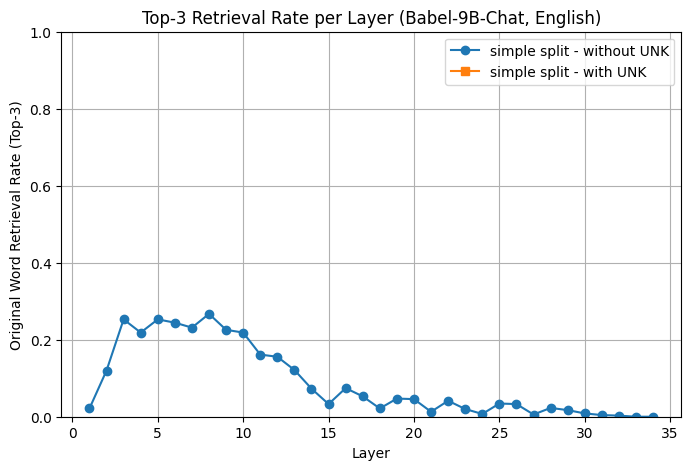

In [67]:
df = df_dict[('Babel-9B-Chat', 'English')]
df_result = pd.read_csv("/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_Babel-9B-Chat_English_v2.csv")
from ast import literal_eval

for col in df_result.columns:
    try:
        # Check if at least one value looks like a list
        if df_result[col].apply(lambda x: isinstance(x, str) and x.strip().startswith("[")).any():
            df_result[col] = df_result[col].apply(literal_eval)
    except (ValueError, SyntaxError):
        continue  # Skip columns that don't parse correctly
df_final = pd.concat([df, df_result.iloc[:,1:]], axis=1)

df_1 = df_final[~df_final.include_UNK]
layers, retrieval_rates_1 = get_retrieval_rates(results_df=df_1)

df_2 = df_final[df_final.include_UNK]
layers, retrieval_rates_2 = get_retrieval_rates(results_df=df_2)

plt.figure(figsize=(8, 5))
plt.plot(layers, retrieval_rates_1, marker='o', label='simple split - without UNK')
plt.plot(layers, retrieval_rates_2, marker='s', label='simple split - with UNK')
plt.xlabel("Layer")
plt.ylabel("Original Word Retrieval Rate (Top-3)")
plt.title(f"Top-3 Retrieval Rate per Layer ({"Babel-9B-Chat"}, {"English"})")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [22]:
splitted_input_tokens = []
for tokens in df["splitted_tokens"]:
    ids = logit_lens.tokenizer.convert_tokens_to_ids(tokens)
    final_toknes = logit_lens.tokenizer.convert_ids_to_tokens(ids)
    splitted_input_tokens.append(final_toknes)
df["splitted_input_tokens"] = splitted_input_tokens
df["include_UNK"] = df['splitted_input_tokens'].apply(lambda x: "UNK" in x)
df['num_UNK'] = df['splitted_input_tokens'].apply(lambda x: x.count("UNK"))
df['proportion_UNK'] = df['splitted_input_tokens'].apply(lambda x: x.count("UNK")/len(x))

In [28]:
df["proportion_UNK"].value_counts(normalize=True)

proportion_UNK
0.000000    0.671429
0.500000    0.194286
0.333333    0.071429
0.250000    0.037143
0.200000    0.021429
0.666667    0.004286
Name: proportion, dtype: float64